In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

ford_list=[]
for i in range(1,4):
    img = cv2.imread('dataset/ford_train'+str(i)+'.jpeg')
    ford_list.append(cv2.resize(img, (128,128)))

img = cv2.imread('dataset/ford_train4.png')
ford_list.append(cv2.resize(img, (128,128)))

img = cv2.imread('dataset/ford_train5.jpeg')
ford_list.append(cv2.resize(img, (128,128)))

volks_list=[]
img = cv2.imread('dataset/volks_train1.png')
volks_list.append(cv2.resize(img, (128,128)))

for i in range(2,6):
    img = cv2.imread('dataset/volks_train'+str(i)+'.jpeg')
    volks_list.append(cv2.resize(img, (128,128)))


In [24]:
class HoG:
    def hog_features(img_list):
        cell_size = (4, 4)  # each cell has 128/32 = 4 pixels
        block_size = (4, 4)  # specified in question
        nbins = 8 
        hog_list = [];
        
        for i in range(len(img_list)):
            img = img_list[i]
            hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

            n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

            # Compute HoG features
            hog_feats = hog.compute(img)\
                           .reshape(n_cells[1] - block_size[1] + 1,
                                    n_cells[0] - block_size[0] + 1,
                                    block_size[0], block_size[1], nbins) \
                           .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

            # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
            # Indexing is by rows then columns.

            # computation for BlockNorm
            gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
            cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

            for off_y in range(block_size[0]):
                for off_x in range(block_size[1]):
                    gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                              off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                        hog_feats[:, :, off_y, off_x, :]
                    cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                               off_x:n_cells[1] - block_size[1] + off_x + 1] += 1
            hog_list.append(hog_feats.flatten())
        return hog_list, gradients, cell_count

(Text(0.5,1,"volks_test res: ['volks']"),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

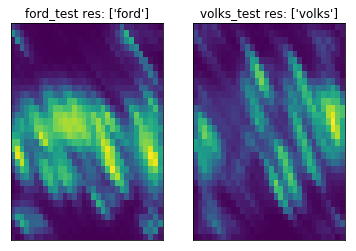

In [25]:
features_all=[]
hog_listVolks, _, _ = HoG.hog_features(volks_list)
hog_listFord, _, _ = HoG.hog_features(ford_list)

features_all.extend(hog_listVolks)
features_all.extend(hog_listFord)
# features_all.extend(HoG.hog_features(volks_list))
# features_all.extend(HoG.hog_features(ford_list))

brand=['volks','volks','volks','volks','volks','ford','ford','ford','ford','ford']

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(features_all, brand) 

bin = 0

test1 = cv2.imread('dataset/ford_test.jpeg')
test1 = cv2.resize(test1, (128,128))
hog_list1, gradients1, cell_count1 = HoG.hog_features([test1])
gradients1 /= cell_count1

plt.subplot(121)
plt.pcolor(gradients1[:, :, bin])
plt.title("ford_test res: "+ str(neigh.predict(hog_list1))), plt.xticks([]), plt.yticks([])
                   
test2 = cv2.imread('dataset/volks_test.jpeg')
test2 = cv2.resize(test2, (128,128))
hog_list2, gradients2, cell_count2 = HoG.hog_features([test2])
gradients2 /= cell_count2

plt.subplot(122)
plt.pcolor(gradients2[:, :, bin])
plt.title("volks_test res: "+ str(neigh.predict(hog_list2))), plt.xticks([]), plt.yticks([])



3.2 Reasoning Questions
1. HoG is not rotation invarient, therefore if the images undergo rotation HoG won't work. In order to fix this we can use SIFT or SURF feauture descriptors.


2. For these 3 images using 1 gradient facing either x or y direction would be sufficient. Since the HoG descriptors in image 2 and 3 would look like mirrored images and HoG descriptors in image 1 would be like overlaying the two other images' HoG descriptors. 

